# Atividade 2

## Análise do dataset Iris

Conforme solicitado na atividade 2, será feita análise do dataset _"Iris"_ fornecido pelo professor, e que encontra-se disponível no [github deste projeto](https://github.com/adrianowead/unicid-ds-alg-03-23).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
df = pd.read_csv('iris.csv')

Abaixo é exibido o início do dataset, para visualizar como estão dispostos os dados neste momento.

In [3]:
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [4]:
# criando uma cópia do dataset com apenas as colunas numéricas
dfk = df.select_dtypes([np.number])

dfk

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [5]:
# parâmetros de inicialização do k-means
kmeans_kwargs = {
  'init': 'random',
  'max_iter': 500,
  'random_state': 10,
  'tol': 1.0e-1,
  'n_init': 100
}

max_clusters = 50

# criando a listra de RMS para armazenar os resultados de cada k clsuter
rms = []

# esse loop reproduz o efeito de rodar várias vezes com quantidade de clusters diferentes
# extamente como o professor orientou, iniciar com 1 cluster e ir aumentando
# com o objetivo de observar o 'joelho' do gráfico
for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dfk)
    
    train_pred = kmeans.predict(dfk)
    rms.append(mean_squared_error(dfk, kmeans.cluster_centers_[train_pred]))

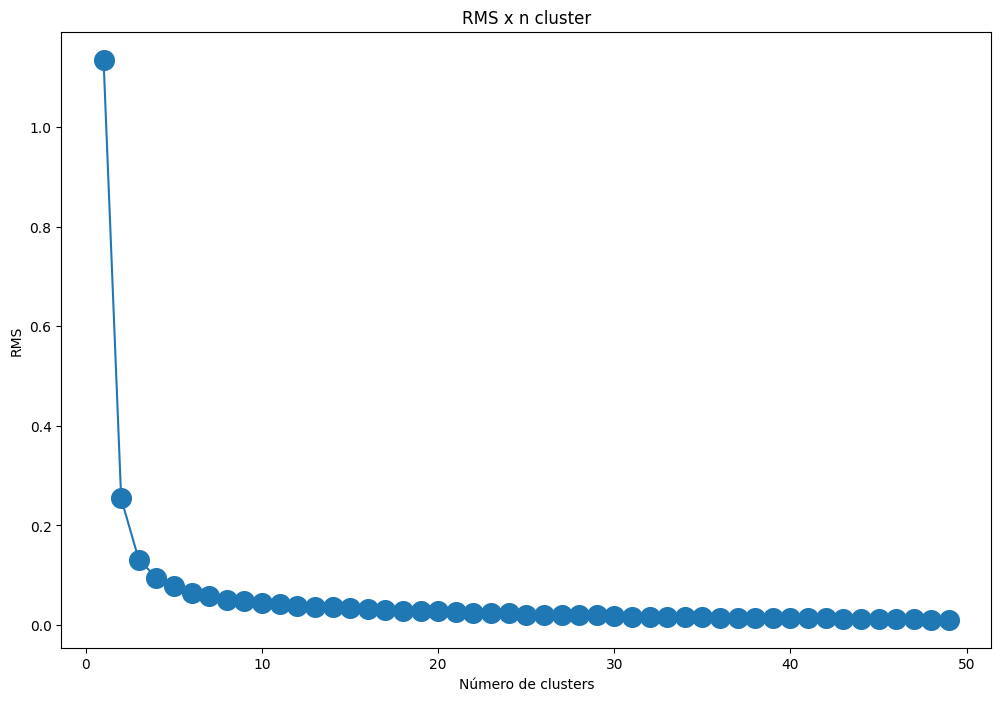

In [6]:
# plotando a curva de RMS
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(range(1, max_clusters), rms, s=200)
ax.plot(range(1, max_clusters), rms)
ax.set_xlabel('Número de clusters')
ax.set_ylabel('RMS')
ax.set_title('RMS x n cluster')
plt.show()

### Ponto de parada

Abaixo vamos executar a mesma verificação, mas com dados de treino e teste.

O objetivo é descobrir se o joelho da curva, que neste caso é próximo ao cluster 5, seria o melhor ponto de parada ou se podemos avançar um pouco mais, antes de um overfit.


In [7]:
"""
Separando dados de treino e teste
utilizando % do dataset para teste
"""
tamanho_treino = 0.2
tamanho_treino = int(len(df) * tamanho_treino)

treino_dfk = df.select_dtypes([np.number])
teste_dfk = treino_dfk.tail(tamanho_treino)

treino_dfk = treino_dfk.iloc[:-tamanho_treino]

print( len(df), len(treino_dfk), len(teste_dfk) )


150 120 30


In [8]:
# criando a listra de RMS para armazenar os resultados de cada k clsuter
rms_treino = []
rms_teste = []

max_clusters = 22

# treino e teste simultâneo
for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(treino_dfk)

    train_pred = kmeans.predict(treino_dfk)
    rms_treino.append(mean_squared_error(treino_dfk, kmeans.cluster_centers_[train_pred]))

    teste_pred = kmeans.predict(teste_dfk)
    rms_teste.append(mean_squared_error(teste_dfk, kmeans.cluster_centers_[teste_pred]))

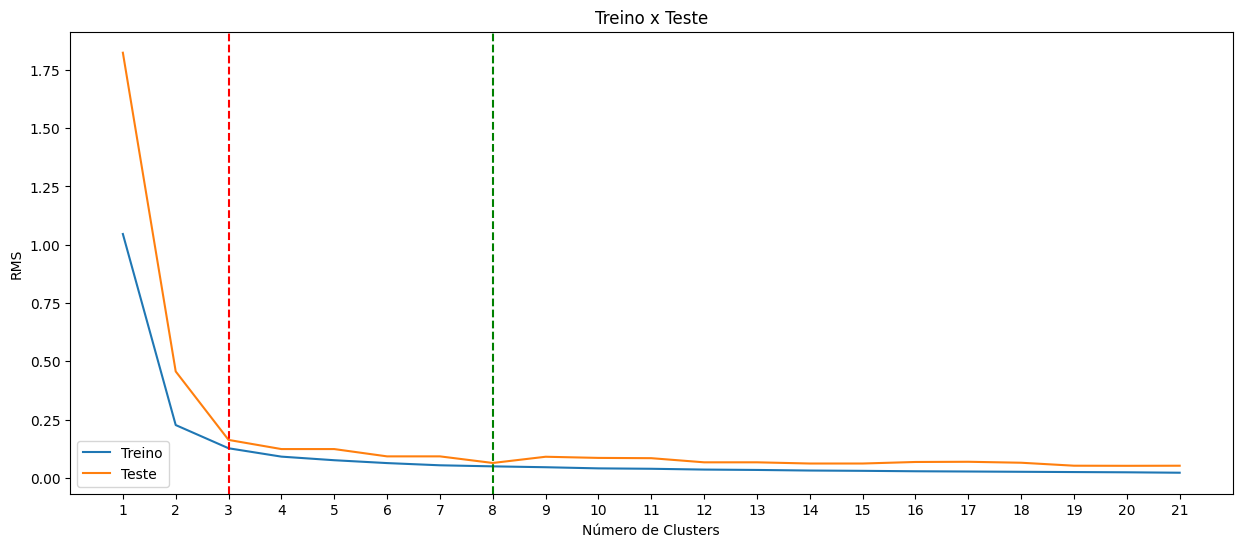

In [9]:
# exibindo o gráfico com os resultados

# Cria um gráfico de linha

fig, ax = plt.subplots(figsize=(15,6))

ax.set_xlabel("Número de Clusters")
ax.set_ylabel("RMS")
ax.set_title("Treino x Teste")

ax.plot(range(1, max_clusters), rms_treino, label="Treino")
ax.plot(range(1, max_clusters), rms_teste, label="Teste")

# Adiciona uma linha pontilhada vertical
ax.axvline(x=3, linestyle='--', color='red')
ax.axvline(x=8, linestyle='--', color='green')

ax.set_xticks(range(1, max_clusters))

ax.legend(loc="lower left")

# Mostra o gráfico
plt.show()

Como observamos na __Atividade 1__ temos também dois possíveis pontos de parada, no joelho da curva que seria o cluster 3, ou no momento em que os dados de treino chegam perto dos de teste, que seria no cluster 8.

### Validando o melhor clsuter

Da mesma maneira que foi feito na __Atividade 1__, precisamos validar o melhor cluster, mas diferente do que foi abordado na outra atividade aqui queremos saber quais clusters acertam mais a coluna __variety__.

Na atividade anterior era saber qual cluster convergia em maior número de vendas (soma), aqui o conceito é parecido, mas usando duas coisas.

- __Coeficiente de Silhouette__: Uma medida interna que avalia a qualidade do agrupamento por meio da distância entre os pontos dentro do mesmo cluster e a distância entre pontos de diferentes clusters. O coeficiente de Silhouette varia de -1 a 1, sendo valores mais altos indicativos de uma melhor separação dos clusters. Podemos calcular o coeficiente de Silhouette para cada número de clusters e selecionar aquele que tiver o valor mais alto.
- __Validação por Especialistas__: Neste caso seria literalmente perguntar para uma pessoa que tenha domínio do negócio/assunto, no nosso caso vamos supor que o melhor cluster é o que acertar mais a coluna __variety__.

#### Validação por Especialistas

In [10]:
# ajustar o modelo KMeans
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(dfk)

# identificado em qual cluster o resultado foi atribuido
df['cluster'] = kmeans.labels_

In [11]:
df

,sepal.length,sepal.width,petal.length,petal.width,variety,cluster
0,5.1,3.5,1.4,0.2,Setosa,1
1,4.9,3.0,1.4,0.2,Setosa,1
2,4.7,3.2,1.3,0.2,Setosa,1
3,4.6,3.1,1.5,0.2,Setosa,1
4,5.0,3.6,1.4,0.2,Setosa,1
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica,0
146,6.3,2.5,5.0,1.9,Virginica,2
147,6.5,3.0,5.2,2.0,Virginica,0
148,6.2,3.4,5.4,2.3,Virginica,0


Aplicando o _Índice de Rand_, a melhor pontuação indicará o melhor cluster, __-1 é pior__ e __1 é melhor__.

In [12]:
# calcular o índice de Rand ajustado
score = adjusted_rand_score(df['variety'], df['cluster'])

print(f"Para 3 clusters, a pontuação foi de: {score}")


Para 3 clusters, a pontuação foi de: 0.7302382722834697


No momento tempos a pontuação de __0.7__ o que indica uma ótima classificação, mas abaixo vamos verificar com 8.

In [13]:
# ajustar o modelo KMeans
kmeans = KMeans(n_clusters=8, **kmeans_kwargs)
kmeans.fit(dfk)

# identificado em qual cluster o resultado foi atribuido
df['cluster'] = kmeans.labels_

In [14]:
# calcular o índice de Rand ajustado
score = adjusted_rand_score(df['variety'], df['cluster'])

print(f"Para 8 clusters, a pontuação foi de: {score}")


Para 8 clusters, a pontuação foi de: 0.42118535592399003


### Conclusão sobre o K-means

Aqui ficou evidente algo que não ocorreu na __Atividade 1__, lá o cluster maior deve melhor desempenho com o cluster indicado na comparação de treino e teste, e neste caso aqui o melhor foi o indicado pelo joelho da curva, com 3 clusters tivemos melhor desempenho do que com 8.

A principal diferença entre os dois foi o fato de que neste segundo experimento, com o dataset iris, a diferença de RMS entre os clusters era baixa. De modo que o acúmulo de treino deixou o cluster 8 mais próximo de um overfit, passando a fazer classificações errôneas.

Isso comprova que cada dataset precisa de uma análise específica, e até mesmo o que é entendido como melhor ou pior depende dos dados e do que pretendemso extrair deles.